# Life Expectancy using Linear Regression
## Milestone 5: Regression Analysis


In [1]:
# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.stats.outliers_influence as sts
from patsy import dmatrices

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import itertools

## 5.1 Build the Model

### 1. Previous Exploration

In [2]:
# Read the resulting file from milestone 3 *state_data_clean.csv* into a dataframe
# Make the columns "Region" and "Division” categorical. 
# Define a new column “Income” that is the result of dividing “Income2017” by 1000. 
df_state = pd.read_csv("~/OneDrive/Documents/manning live projects/Life Expectancy/state_data_clean.csv", delimiter=",")
df_state.set_index("State")
df_state["Region"].astype("category")
df_state["Division"].astype("category")
df_state["Income"] = df_state["Income2017"]/1000
df_state.rename(
  columns={
    "MurderTOT" : "MurderTot"
  },
  inplace=True
)
print(df_state)




             State  LifeExp2018  Income2017  HSGradPer  BADegPer  AdvDegPer  \
0           Alaska    78.800003       73181       92.4      29.0       10.4   
1          Arizona    79.900002       56581       82.1      28.4       10.7   
2         Arkansas    75.900002       45869       85.6      22.0        7.9   
3       California    81.599998       71805       82.5      32.6       12.2   
4         Colorado    80.500000       69117       91.1      39.4       14.6   
5      Connecticut    80.900002       74168       90.2      38.4       17.0   
6         Delaware    78.400002       62852       89.3      31.0       12.9   
7          Georgia    77.800003       56183       86.3      29.9       11.4   
8           Hawaii    82.300003       77765       91.6      32.0       10.8   
9            Idaho    79.300003       52225       90.2      26.8        8.5   
10        Illinois    79.300003       62992       88.6      33.4       13.0   
11         Indiana    77.000000       54181       88

In [3]:
# check that everything was correctly loaded
print(df_state.head())
print(df_state.dtypes)
print(df_state.describe())

        State  LifeExp2018  Income2017  HSGradPer  BADegPer  AdvDegPer  \
0      Alaska    78.800003       73181       92.4      29.0       10.4   
1     Arizona    79.900002       56581       82.1      28.4       10.7   
2    Arkansas    75.900002       45869       85.6      22.0        7.9   
3  California    81.599998       71805       82.5      32.6       12.2   
4    Colorado    80.500000       69117       91.1      39.4       14.6   

   Population  MurderNMTot  MurderTot  GunMurderTot  ...  MurderRate  \
0      737709           59       57.0          39.0  ...         7.7   
1     6817565          306      278.0         171.0  ...         4.1   
2     2977853          181      164.0         110.0  ...         5.5   
3    38993940         1861     1861.0        1275.0  ...         4.8   
4     5448819          176      176.0         115.0  ...         3.2   

   GunMurderRate  TotalKmQ  LandKmQ  WaterKmQ  Abb  Region  \
0            5.3   1723337  1477953    245384   AK    West  

In [11]:
#convert Region to new columns for each different catagorical value
df_dummies = pd.get_dummies(df_state['Region'])
#del df_dummies[df_dummies.columns[-1]]
df_new = pd.concat([df_state, df_dummies], axis = 1)

df_new.rename(
  columns={
    "North Central" : "Northcentral"
  },
  inplace=True
)
df_new.head()

,State,LifeExp2018,Income2017,HSGradPer,BADegPer,AdvDegPer,Population,MurderNMTot,MurderTot,GunMurderTot,...,WaterKmQ,Abb,Region,Division,Pop,Income,Northcentral,Northeast,South,West
0,Alaska,78.800003,73181,92.4,29.0,10.4,737709,59,57.0,39.0,...,245384,AK,West,Pacific,737.709,73.181,0,0,0,1
1,Arizona,79.900002,56581,82.1,28.4,10.7,6817565,306,278.0,171.0,...,1026,AZ,West,Mountain,6817.565,56.581,0,0,0,1
2,Arkansas,75.900002,45869,85.6,22.0,7.9,2977853,181,164.0,110.0,...,2961,AR,South,west south central,2977.853,45.869,0,0,1,0
3,California,81.599998,71805,82.5,32.6,12.2,38993940,1861,1861.0,1275.0,...,20501,CA,West,Pacific,38993.940,71.805,0,0,0,1
4,Colorado,80.500000,69117,91.1,39.4,14.6,5448819,176,176.0,115.0,...,1170,CO,West,Mountain,5448.819,69.117,0,0,0,1


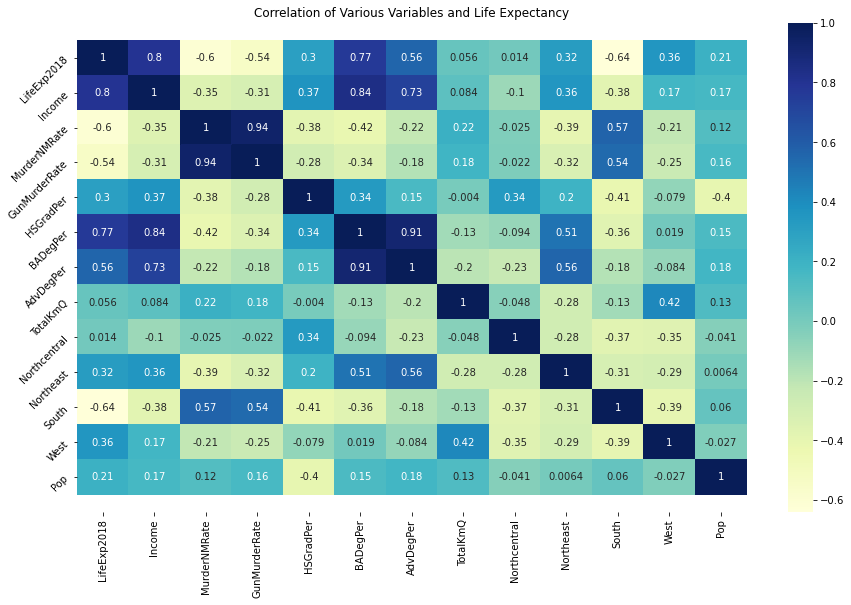

In [186]:
# You will find a regression model for "LifeExp2018" using the following regressors:
# “Income”, “MurderNMRate”, “GunMurderRate”, “HSGradPer”, “BADegPer”, “AdvDegPer”, 'TotalKmQ', 'Region', and 'Pop'
# First compute the correlation matrix between the variables and plot a heatmap

corr_cols = ['Income', 'MurderNMRate', 'GunMurderRate', 'HSGradPer', 'BADegPer',
                  'AdvDegPer', 'TotalKmQ', 'Northcentral', 'Northeast', 'South', 'West', 'Pop']
df_corr = df_new.loc[:,['LifeExp2018']+corr_cols]
corr_matrix = df_corr.corr()
# Heatmap showing the correlation of certain variables and life expectancy
fig, ax0 = plt.subplots(figsize = (15,9))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", ax = ax0)
# margins bug
b, t = plt.ylim()
plt.ylim(b + 0.5, t-0.5)
plt.yticks(rotation=45)
ax0.set_title("Correlation of Various Variables and Life Expectancy")
#plt.savefig("./img/heatmap_edu.png")
plt.show()


<ipython-input-187-7509e5638c40>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(df_corr, alpha=0.2, diagonal = 'hist', ax = ax0)


(array([ 0., 10., 20., 30.]),
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

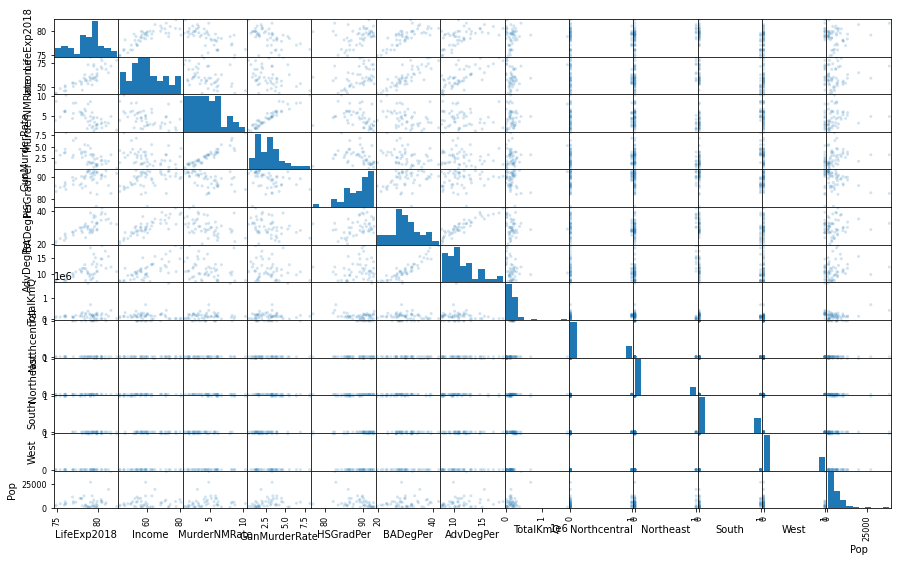

In [187]:
# Plot a scatterplot matrix
fig, ax0 = plt.subplots(figsize = (15,9))
pd.plotting.scatter_matrix(df_corr, alpha=0.2, diagonal = 'hist', ax = ax0)
#sns.pairplot(df_new)
ax0.set(title="Scatterplot Matrix")
# margins bug
b, t = plt.ylim()
plt.ylim(b + 0.5, t-0.5)
plt.yticks(rotation=45)
#plt.show()


In [14]:
def forward_selection(df, response):
    """Linear model by all subsets selection.

    Parameters:
    -----------
    df : pandas DataFrame with all variables
    predictor : name of the predictor variable

    Returns:
    --------
    list of the selected models
    list pf corresponding adjusted R^2
    list of strings columns corresponding to the predictors that make the "optimal" model
    """  
    
    selected_models, selected_scores, selected_preds = [], [], []
    max_score, best_score = 0.0, 0.0
    remaining_preds = set(df.columns)
    remaining_preds.remove(response)
    
    while remaining_preds and max_score == best_score:
        list_scores_models = []
        for new_pred in remaining_preds:
            current_formula = "{} ~ {} ".format(response,' + '.join(selected_preds + [new_pred]))
            y, current_X = dmatrices(current_formula, data=df, return_type='dataframe')
            # do the regression and compute R^2 
            model = sm.OLS(y, current_X)    # Describe model
            results = model.fit()       # Fit model
            adjRsqr = results.rsquared_adj 
            list_scores_models.append((adjRsqr, new_pred, model))
        # which of the examined candidates gave the biggest adjR^2
        list_scores_models.sort()
        best_score, best_pred, best_model = list_scores_models.pop()
        print("Best model adds {} - adjR2: {}".format(best_pred,best_score))
        if max_score < best_score:
            remaining_preds.remove(best_pred)
            selected_models.append(best_model)
            selected_scores.append(best_score)
            selected_preds.append(best_pred)
            max_score = best_score
    return (selected_models,selected_scores, selected_preds)



### 3. Build the model

In [189]:
# Run forward_selection to find the best model using the variables 'LifeExp2018', 'Income', 'MurderNMRate', 'GunMurderRate', 'HSGradPer', 'BADegPer', 'AdvDegPer', 'TotalKmQ', 'Region', and 'Pop'

selected_models, selected_scores, selected_preds = forward_selection(df_corr, 'LifeExp2018')


Best model adds Income - adjR2: 0.6320429798543008
Best model adds South - adjR2: 0.7636972896362202
Best model adds MurderNMRate - adjR2: 0.7953898351058871
Best model adds Pop - adjR2: 0.8179880116304898
Best model adds West - adjR2: 0.8254805134001276
Best model adds BADegPer - adjR2: 0.8415408623440663
Best model adds AdvDegPer - adjR2: 0.858086810272618
Best model adds HSGradPer - adjR2: 0.8623919431817226
Best model adds TotalKmQ - adjR2: 0.8597997838332962


Text(0.5, 1.0, 'Regressor vs. Adjusted R^2')

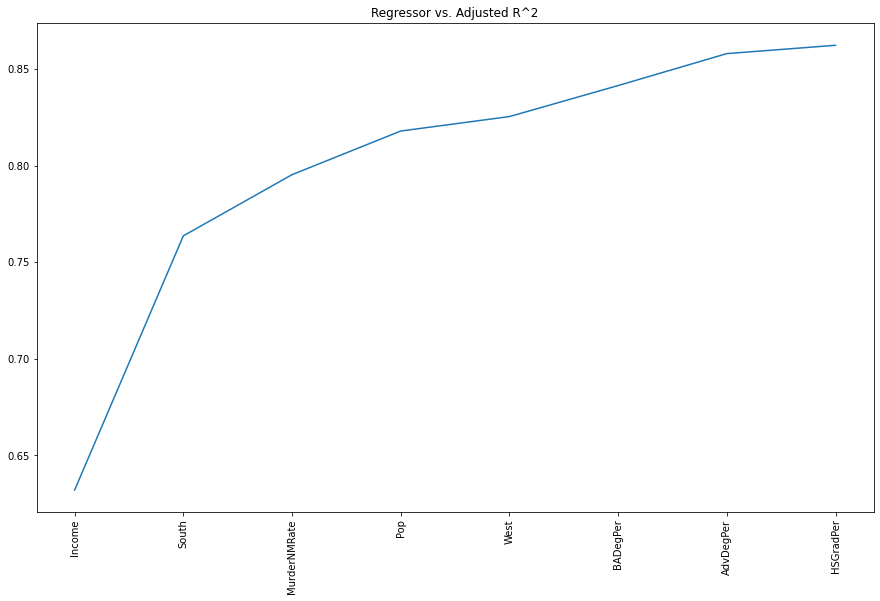

In [190]:
# With the results plot the number of regressor (or the name of the added regressor) against the adjusted R^2 for the best model with that number of regressors.
fig, ax0 = plt.subplots(figsize = (15,9))
plt.plot(selected_preds, selected_scores)
plt.xticks(rotation = 90)
ax0.set_title("Regressor vs. Adjusted R^2")

### 4. Multicollinearity

In [192]:
# function to compute variance inflation factor
def compute_vif(formula,df):
    y, X = dmatrices(formula, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [sts.variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif["Sqrt"] = np.sqrt(vif["VIF Factor"])
    vif["features"] = X.columns
    return vif

In [193]:
# Exploring multicollinearity

# Run a regression of 'LifeExp2018 ~ BADegPer’ and print the results
formula = 'LifeExp2018 ~ BADegPer'

y0, X0 = dmatrices(formula, data=df_corr, return_type='dataframe')
mod0 = sm.OLS(y0, X0)    # Describe model
mod0 
fit0 = mod0.fit()       # Fit model
print('Model parameters for regression: '+ 'LifeExp2018 ~ BADegPer')
print(fit0.params.apply(lambda x: "{:.8f}".format(x))) 

Model parameters for regression: LifeExp2018 ~ BADegPer
Intercept    70.68056221
BADegPer      0.26628557
dtype: object


In [194]:
# Run a regression of 'LifeExp2018 ~ AdvDegPer' and print the results
formula = 'LifeExp2018 ~ AdvDegPer'
df_state
y0, X0 = dmatrices(formula, data=df_corr, return_type='dataframe')
mod0 = sm.OLS(y0, X0)    # Describe model
mod0 
fit0 = mod0.fit()       # Fit model
print('Model parameters for regression: '+ 'LifeExp2018 ~ AdvDegPer')
print(fit0.params.apply(lambda x: "{:.8f}".format(x))) 

Model parameters for regression: LifeExp2018 ~ AdvDegPer
Intercept    74.65945463
AdvDegPer     0.36021007
dtype: object


In [195]:
# Run a regression of ''LifeExp2018 ~ BADegPer + AdvDegPer' and print the results
formula = 'LifeExp2018 ~ BADegPer + AdvDegPer'

y0, X0 = dmatrices(formula, data=df_corr, return_type='dataframe')
mod0 = sm.OLS(y0, X0)    # Describe model
mod0 
fit0 = mod0.fit()       # Fit model
print('Model parameters for regression: '+ 'LifeExp2018 ~ BADegPer + AdvDegPer')
print(fit0.params.apply(lambda x: "{:.8f}".format(x)))   

Model parameters for regression: LifeExp2018 ~ BADegPer + AdvDegPer
Intercept    68.78092582
BADegPer      0.53136899
AdvDegPer    -0.54056305
dtype: object


In [196]:
# For the last regression compute the variance inflation factor
formula = 'LifeExp2018 ~ BADegPer + AdvDegPer'
compute_vif(formula,df_corr)

,VIF Factor,Sqrt,features
0,47.082734,6.861686,Intercept
1,5.927523,2.434651,BADegPer
2,5.927523,2.434651,AdvDegPer


Compare the coefficients of the three regressions.    
Take note of the VIFs

The coefficients of BADegPer and AdvDegPer changes significantly when both of these regressors are used to model the dependent variable LifeExp2018 as compared to when each regressor is modeled separately agains LifeExp2018.  This implys strong multicollinearity.

The VIF sqrt is greater than 2 for both BADegPer and AdvDegPer when used together in the model.  This is another indicator that multicollinearity exists between these two regressors.


### Analysis of the models returned 

In [55]:
def compare_regs(formula, df) :
    y, X = dmatrices(formula, data=df, return_type='dataframe')
    mod = sm.OLS(y, X)    # Describe model
    mod 
    fit = mod.fit()       # Fit model
    print('Model parameters for regression: '+ formula)
    print(fit.params.apply(lambda x: "{:.8f}".format(x))) 
    # run the summary() method for model
    print(fit.summary())

    # plot heatmap of the variables

    corr_matrix = df.corr()
    # Heatmap showing the correlation of Income and life expectancy
    fig, ax0 = plt.subplots(figsize = (15,9))
    sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", ax = ax0)
    # margins bug
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t-0.5)
    plt.yticks(rotation=45)
    ax0.set_title("Correlation of " + formula)

    # compute vif
    vif = compute_vif(formula,df)
    print(vif)
    

##### Model with one predictor
##### LifeExp2018 ~ Income

Model parameters for regression: LifeExp2018 ~ Income
Intercept    70.12529270
Income        0.14311009
dtype: object
                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     81.73
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           9.09e-12
Time:                        13:24:11   Log-Likelihood:                -70.292
No. Observations:                  48   AIC:                             144.6
Df Residuals:                      46   BIC:                             148.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

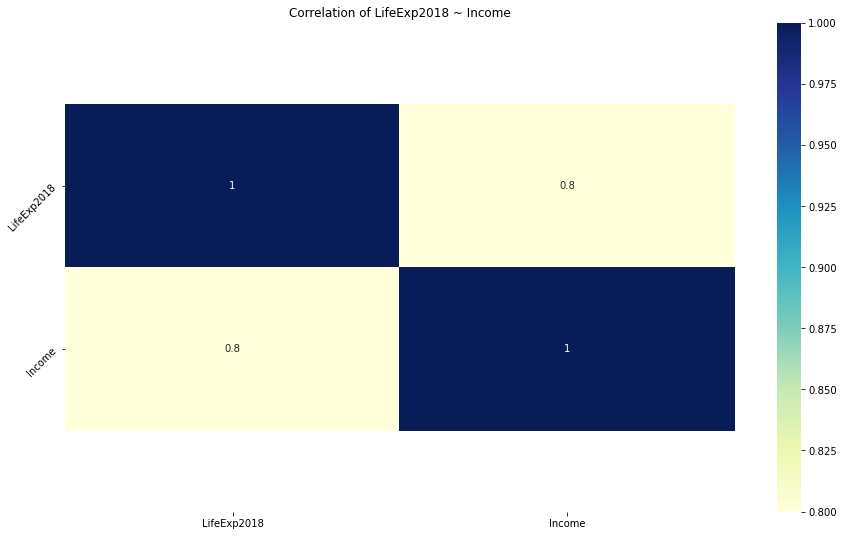

In [197]:
#Model with one regressor
formula = 'LifeExp2018 ~ Income'
corr_cols_1 = ['Income']
df_reg1 = df_new.loc[:,['LifeExp2018']+corr_cols_1]
compare_regs(formula, df_reg1)

##### Model with 2 predictors
##### LifeExp2018 ~ Income + Region of South

Model parameters for regression: LifeExp2018 ~ Income + South
Intercept    72.16833465
Income        0.11651119
South        -1.51529768
dtype: object
                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     76.95
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           3.01e-15
Time:                        13:24:35   Log-Likelihood:                -59.136
No. Observations:                  48   AIC:                             124.3
Df Residuals:                      45   BIC:                             129.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     

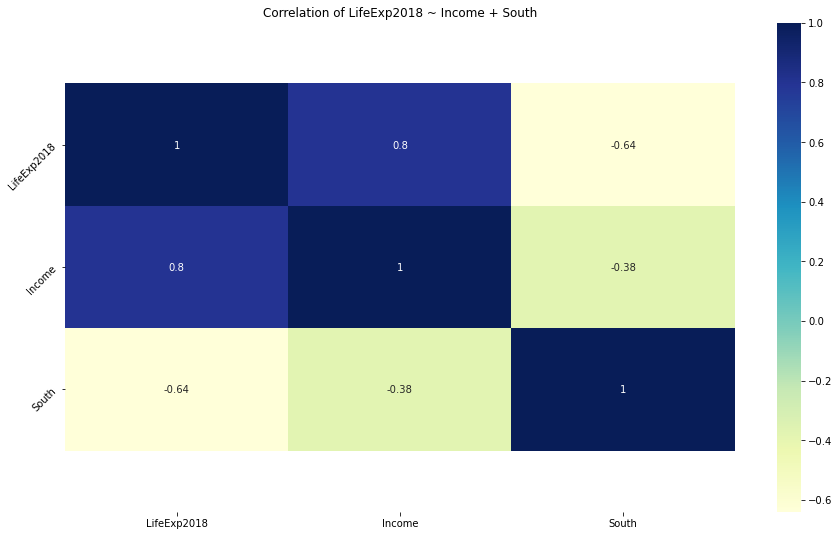

In [198]:
#Model with two regressors
formula = 'LifeExp2018 ~ Income + South'
corr_cols = ['Income', 'South']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]
compare_regs(formula, df_reg)

##### Model with 3 predictors
##### LifeExp2018 ~ Income + South + MurderNMRate 

Model parameters for regression: LifeExp2018 ~ Income + South + MurderNMRate
Intercept       73.26586031
Income           0.10991663
South           -1.06899827
MurderNMRate    -0.18447389
dtype: object
                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     61.90
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           7.89e-16
Time:                        13:24:49   Log-Likelihood:                -55.140
No. Observations:                  48   AIC:                             118.3
Df Residuals:                      44   BIC:                             125.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
       

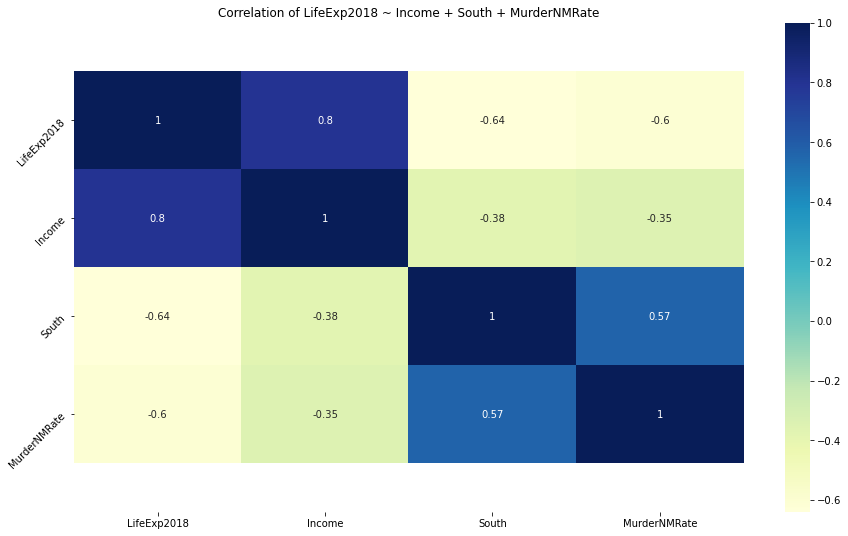

In [199]:
#Model with three regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate'
corr_cols = ['Income', 'South', 'MurderNMRate']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]
compare_regs(formula, df_reg)

##### Model with 4 predictors
##### LifeExp2018 ~ Income + South + MurderNMRate + Pop

Model parameters for regression: LifeExp2018 ~ Income + South + MurderNMRate + Pop
Intercept       73.56689284
Income           0.10264942
South           -1.10252180
MurderNMRate    -0.20771286
Pop              0.00004079
dtype: object
                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     53.81
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           3.46e-16
Time:                        13:25:52   Log-Likelihood:                -51.780
No. Observations:                  48   AIC:                             113.6
Df Residuals:                      43   BIC:                             122.9
Df Model:                           4                                         
Covariance Type:            nonrobust               

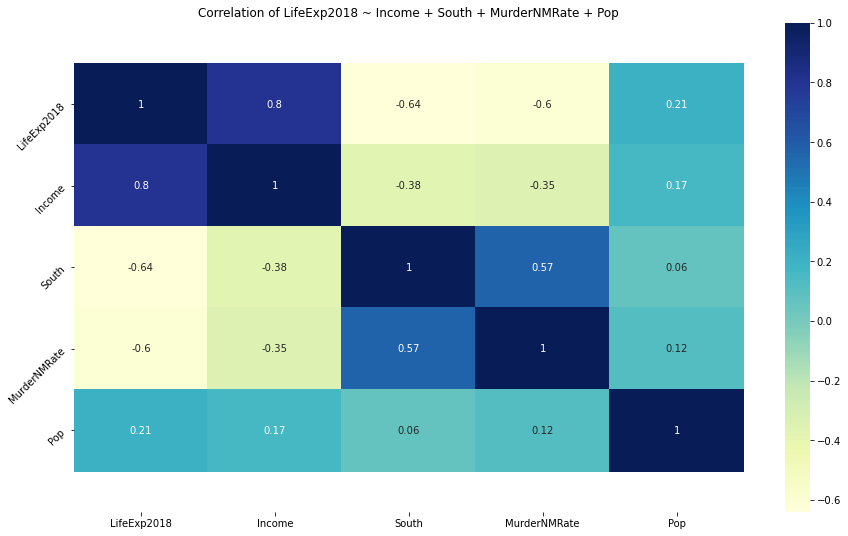

In [202]:
#Model with four regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]
compare_regs(formula, df_reg)

##### Model with 5 predictors
##### LifeExp2018 ~ Income + South + MurderNMRate + Pop + West 

Model parameters for regression: LifeExp2018 ~ Income + South + MurderNMRate + Pop + West
Intercept       73.45367985
Income           0.10187544
South           -0.93532942
MurderNMRate    -0.20995010
Pop              0.00004117
West             0.43867707
dtype: object
                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     45.46
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           7.00e-16
Time:                        13:25:59   Log-Likelihood:                -50.206
No. Observations:                  48   AIC:                             112.4
Df Residuals:                      42   BIC:                             123.6
Df Model:                           5                                         
Covariance Type: 

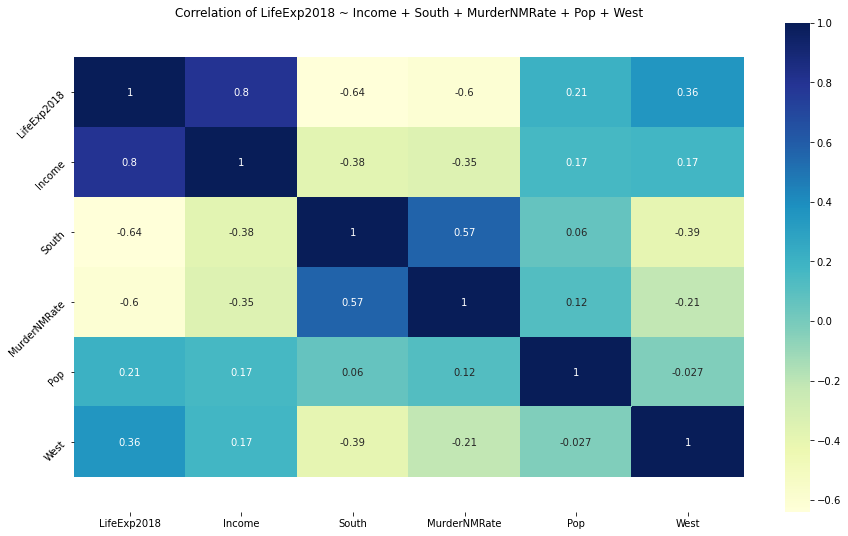

In [203]:
#Model with five regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop', 'West']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]
compare_regs(formula, df_reg)

##### Model with 6 predictors
##### LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer

Model parameters for regression: LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer
Intercept       72.75085032
Income           0.06417476
South           -0.88713998
MurderNMRate    -0.17813086
Pop              0.00003907
West             0.61418973
BADegPer         0.09186323
dtype: object
                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     42.60
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           4.40e-16
Time:                        13:26:11   Log-Likelihood:                -47.311
No. Observations:                  48   AIC:                             108.6
Df Residuals:                      41   BIC:                             121.7
Df Model:                           6                    

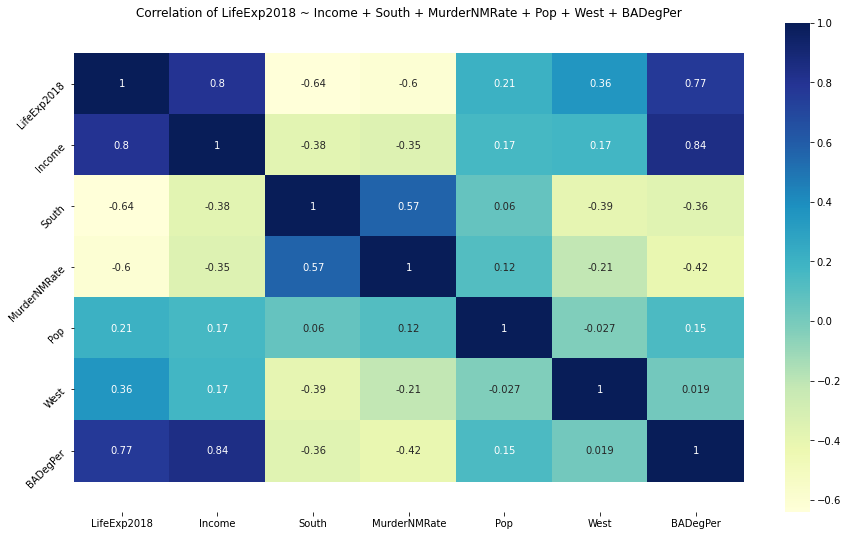

In [204]:
#Model with six regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop', 'West', 'BADegPer']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]
compare_regs(formula, df_reg)

##### Model with 7 predictors
##### LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer + AdvDegPer

Model parameters for regression: LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer + AdvDegPer
Intercept       71.41359173
Income           0.05701799
South           -0.75659658
MurderNMRate    -0.13665870
Pop              0.00004009
West             0.58359597
BADegPer         0.23272761
AdvDegPer       -0.23995463
dtype: object
                            OLS Regression Results                            
Dep. Variable:            LifeExp2018   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     41.60
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           2.13e-16
Time:                        13:26:31   Log-Likelihood:                -44.071
No. Observations:                  48   AIC:                             104.1
Df Residuals:                      40   BIC:                             119.1
Df Model:        

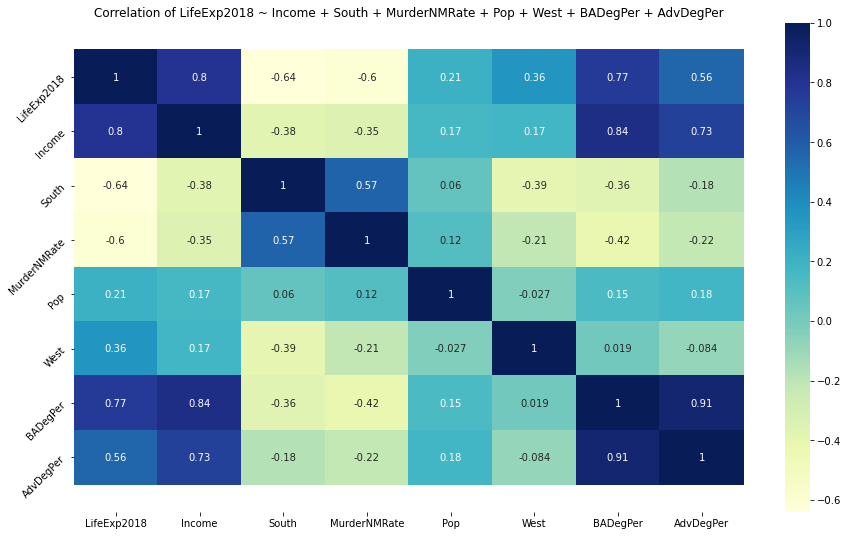

In [205]:
#Model with seven regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer + AdvDegPer'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop', 'West', 'BADegPer', 'AdvDegPer']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]
compare_regs(formula, df_reg)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'LifeExp2018 vs. AdvDegPer')

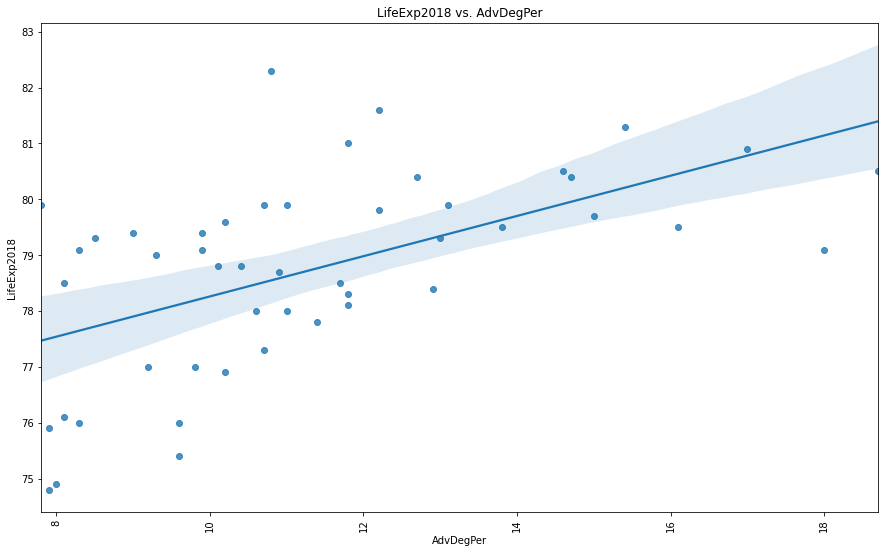

In [206]:
# Regression plot for life expectancy vs. advanced degree

fig, ax0 = plt.subplots(figsize = (15,9))
sns.regplot(df_new['AdvDegPer'], df_new['LifeExp2018'])
plt.xticks(rotation = 90)
ax0.set_title("LifeExp2018 vs. AdvDegPer")

# Check the plot against the coefficient of the regression

## 5.2 Regression Diagnostics

We have tested the unusual observations on the regression of LifeExp2018 on MurderNMTot.   
Now run a regression of our selected model.

In [207]:
def Q_Q_plot(fit):
    """ Prints a Q-Q plot    
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax
    
    annotates observations with abs(studentized residual) >= 2
    """
  
    student_resid = pd.Series(fit.get_influence().resid_studentized_internal, index = fit.resid.index, name='StudentResid')
    student_resid.sort_values(ascending = True, inplace= True)
    df = pd.DataFrame(student_resid)
    df['TheorQuant'] = stats.probplot(df['StudentResid'], dist = 'norm', fit = False)[0]
    rankings = abs(df['StudentResid']).sort_values(ascending = False)

    fig, ax0 = plt.subplots()
    x = df['TheorQuant']
    y = df['StudentResid']
    ax0.scatter(x,y)
    ax0.set(title ='Normal Q-Q', xlabel = 'Theoretical Quantiles', ylabel = 'Standardized Residuals')
    ax0.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for id, val in student_resid.items():
        if abs(val) >= 2:
            ax0.annotate(id,xy=(df['TheorQuant'].loc[id],df['StudentResid'].loc[id]))
    return fig, ax0

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>)

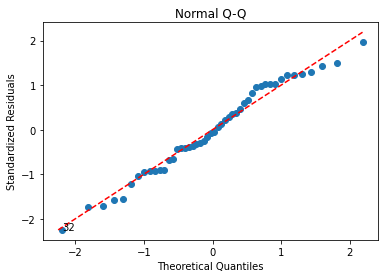

In [208]:
# Use the Q-Q-Plot to check if the selected model satisfies the normality assumption
#Model with six regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop', 'West', 'BADegPer']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]

y, X = dmatrices(formula, data=df_reg, return_type='dataframe')
mod = sm.OLS(y, X)    # Describe model 
fit = mod.fit()
Q_Q_plot(fit)

Program a function residuals_vs_fitted that plots the residuals (property resid of the fit) vs. the fitted values (property fittedvalues of the fit). Add a lowess curve (you can use the lowess function).  
Pass as arguments the fit and the number of observations that you want to annotate. Annotate the biggest n residuals.

In [209]:
def residuals_vs_fitted(fit, n ):
    """ Prints a residuals vs fitted plot    
    Parameters
    ----------
    fit: fitted model
    n: annotate the top n observations (the ones with the largest residuals)
    
    Returns
    -------
    plot as figure, axis
    """

    fig, ax0 = plt.subplots(figsize = (9,8))

    # plot residuals vs. fitted
    residuals = fit.resid
#     print('residuals', residuals)
    fitted = fit.fittedvalues
#     print('fitted', fitted)
    ax0.scatter(fitted, residuals)

    # plot a lowess red curve
    curve = lowess(residuals,fitted)
    curve_x = curve[:,0]
    curve_y = curve[:,1]
    ax0.plot(curve_x,curve_y,color = 'r')

    # plot a dashed horizontal line at zero
    ax0.axhline(y=0, color='green', linestyle='dashed', linewidth=1)

    # set title and labels
    ax0.set(title ='residuals_vs_fitted', xlabel = 'fitted', ylabel = 'residuals')

    # annotate top n observations (the ones with the largest residuals in absolute value)
    sorted_resids = residuals.reindex(residuals.abs().sort_values().index)
    largest_resids = sorted_resids[-n : :]
    for idx, val in largest_resids.items():
        x_val = fitted[idx]
        ax0.annotate(val, xy=(x_val,val))
    
    return fig, ax0

(<Figure size 648x576 with 1 Axes>,
 <AxesSubplot:title={'center':'residuals_vs_fitted'}, xlabel='fitted', ylabel='residuals'>)

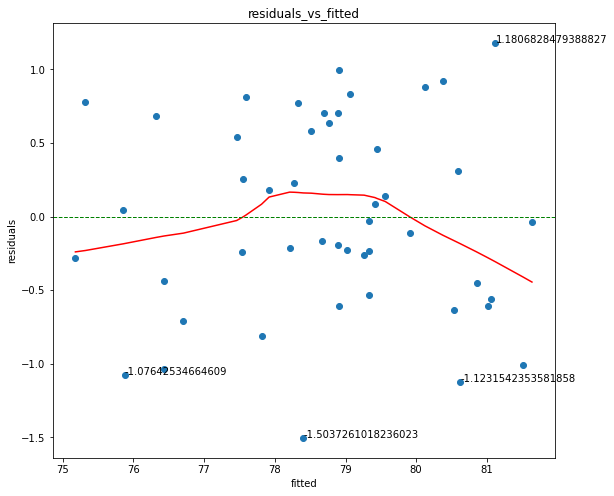

In [210]:
# Use the residuals_vs_fitted plot to check if the selected model satisfies the linearity assumption
#Model with six regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop', 'West', 'BADegPer']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]

y, X = dmatrices(formula, data=df_reg, return_type='dataframe')
mod = sm.OLS(y, X)    # Describe model 
fit = mod.fit()
residuals_vs_fitted(fit, 4 )

In [211]:
def scale_location_plot(fit, n):
    """ Prints a scale-location plot    
    Parameters
    ----------
    fit: fitted model
    n: annotate the top n observations
    
    Returns
    -------
    plot as fig, ax
    """

    fig, ax0 = plt.subplots( figsize = (9,8))

    # plot the square root of the studentized residuals vs. the fitted values
    student_resid = pd.Series(fit.get_influence().resid_studentized_internal, index = fit.resid.index,
                              name='StudentResid')
#     student_resid.sort_values(ascending = True, inplace= True)
    sqrt_student_resid = student_resid.apply(lambda x: x ** 1/2)
    
    fitted = fit.fittedvalues

    ax0.scatter(fitted, sqrt_student_resid)

    # plot a lowess red curve
    smoothed = lowess(sqrt_student_resid,fitted)
    ax0.plot(smoothed[:,0],smoothed[:,1],color = 'r')

    # set title and labels
    ax0.set(title ='sqrt studentized resids_vs_fitted', xlabel = 'fitted', ylabel = 'sqrt studentized resids')

    # annotate the top n observations (the ones with the largest residuals in absolute value)
    sorted_resids = sqrt_student_resid.reindex(sqrt_student_resid.abs().sort_values().index)
    largest_resids = sorted_resids[-n : :]
    for idx, val in largest_resids.items():
        x_val = fitted[idx]
        ax0.annotate(val, xy=(x_val,val))


    return fig, ax0

(<Figure size 648x576 with 1 Axes>,
 <AxesSubplot:title={'center':'sqrt studentized resids_vs_fitted'}, xlabel='fitted', ylabel='sqrt studentized resids'>)

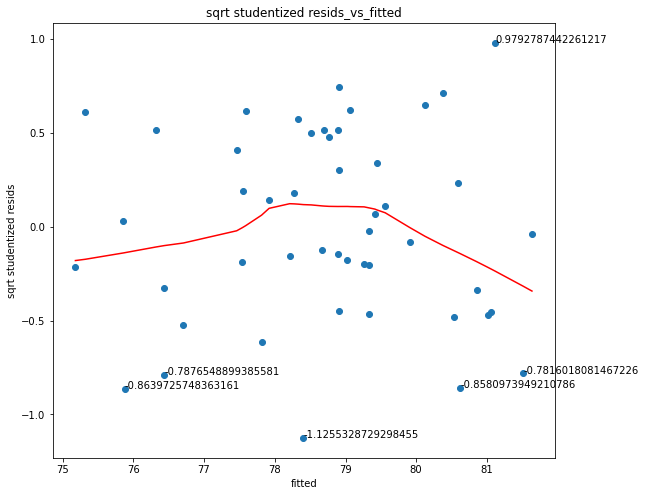

In [212]:
# Use the scale_location plot to check if the selected model satisfies the constant variance assumption
#Model with six regressors
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop', 'West', 'BADegPer']
df_reg = df_new.loc[:,['LifeExp2018']+corr_cols]

y, X = dmatrices(formula, data=df_reg, return_type='dataframe')
mod = sm.OLS(y, X)    # Describe model 
fit = mod.fit()
scale_location_plot(fit, 6 )

In [213]:
# Copy the function check-outliers from milestone 4
def check_outliers(fit, bound = 2):
    """ Prints studentized redisuals whose absolute value exceed 2
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    nothing
    """
    influence_obj = fit.get_influence()
    student_resid = influence_obj.resid_studentized_internal
    student_resid_series = pd.Series(student_resid, index = fit.resid.index, name = 'StudentResid')
    print("Outliers\nStudentized residuals")
    for id, val in student_resid_series.items():
        if abs(val) >= bound:
            print(id, val)
    return

In [224]:
# test the selected model for outliers
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer'
corr_cols = ['Income', 'South', 'MurderNMRate', 'Pop', 'West', 'BADegPer']
df_reg = df_new.loc[:,['State', 'LifeExp2018']+corr_cols]
df_reg.set_index("State")

y, X0 = dmatrices(formula , data=df_reg, return_type='dataframe')
mod = sm.OLS(y, X0)    # Describe model
fit = mod.fit()       # Fit model
check_outliers(fit, 1.9)

Outliers
Studentized residuals
8 1.9585574884522434
32 -2.251065745859691


In [225]:
# Copy the function hat_values_plot from milestone 4
def hat_values_plot(fit):
    """ Prints hat values plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    h_bar = p/n : mean hat value
    Observations whose hat values are >= 2 * h_bar are annotated
    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    """
    # number of regressors + 1
    p = len(fit.params)
    # number of observations
    n = len(fit.fittedvalues)
    # mean hat value
    mean_hat = p/n
    # get OLSInfluence Object
    influence_obj = fit.get_influence()
    # retrieve hat values
    hat_values = influence_obj.hat_matrix_diag # get the hat values from the OLSInfluence object
    hat_values_series = pd.Series(hat_values, index = fit.resid.index, name='HatValues')
    fig, ax0 = plt.subplots(figsize = (15,9))
    ax0.set(title="Index Plot of Hat Values")
    
    
    ax0.axhline(y=2*mean_hat, color='g', linestyle='--', linewidth=1, label = "mean hat * 2")
    ax0.axhline(y=3*mean_hat, color='r', linestyle='--', linewidth=1, label = "mean hat * 3")
    markerline, stemlines, baseline = ax0.stem(hat_values_series.index,hat_values_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)
    plt.xticks(rotation =90)
    # annotate hat values that >= 2 * mean_hat
    bound = 2 * mean_hat
    print("Hat values greater than bound: {:.4f}".format(bound))
    for id, val in hat_values_series.items():
        if val >= bound:
            ax0.annotate(id,xy=(id,val))
            print("{}: {:.2f}".format(id,val))
    ax0.legend()
    return fig, ax0

Hat values greater than bound: 0.2917
0: 0.34
3: 0.56
17: 0.34
40: 0.30


(<Figure size 1080x648 with 1 Axes>,
 <AxesSubplot:title={'center':'Index Plot of Hat Values'}>)

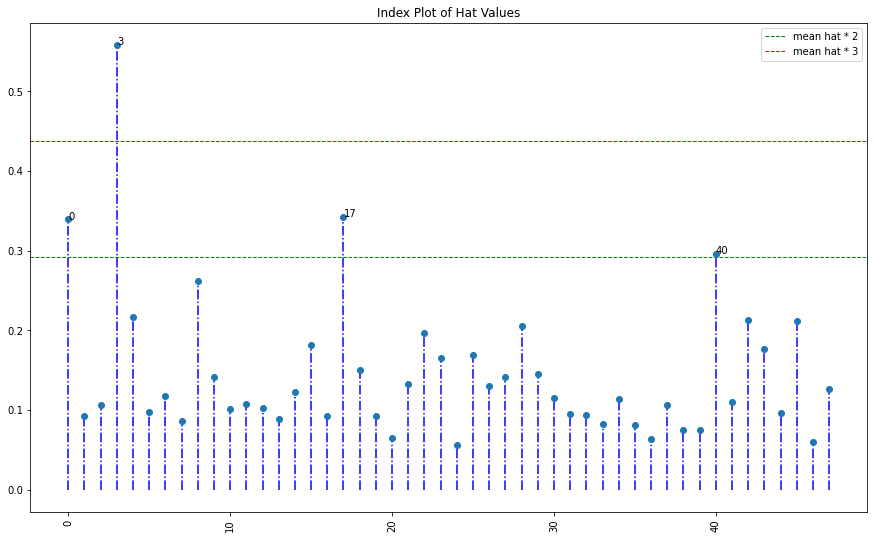

In [226]:
# test the selected model for high-leverage points
hat_values_plot(fit)

In [227]:
# Copy the function cooks_dist_plot from milestone 4
def cooks_dist_plot(fit):
    """ Prints a Cook's distance plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    observations with a Cook's distance that exceeds 4/(n-p-2) should be annotated

    """

    p = len(fit.params)
    n = len(fit.fittedvalues)
    bound = 4/(n-p-2)

    # get OLSInfluence Object
    influence_obj = fit.get_influence()
    # get Cook's distances
    cooks_dist = influence_obj.cooks_distance[0] # get the cook's distances from the OLSInfluence object
    cooks_dist_series = pd.Series(cooks_dist, index = fit.resid.index, name='CookDist')
    # plot the distances
    fig, ax0 = plt.subplots(figsize = (15,9))
    ax0.set(title="Cook's Distance Plot")
    ax0.axhline(y=bound, color='g', linestyle='--', linewidth=1, label ="4/(n-k-1)")
    ax0.axhline(y=1, color='r', linestyle='--', linewidth=1, label ="1")
 
    markerline, stemlines, baseline = ax0.stem(cooks_dist_series.index,cooks_dist_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)
    plt.xticks(rotation =90)
    # annotate values with Cook's distance >= bound
    print("Observations with Cook's distance greater that bound: {:.4f}".format(bound))
    for id, val in cooks_dist_series.items():
        if val >= bound:
            ax0.annotate(id,xy=(id,val))
            print("{}: {:.2f}".format(id,val))
    ax0.legend()
    return fig, ax0  

Observations with Cook's distance greater that bound: 0.1026
8: 0.19
45: 0.11


(<Figure size 1080x648 with 1 Axes>,
 <AxesSubplot:title={'center':"Cook's Distance Plot"}>)

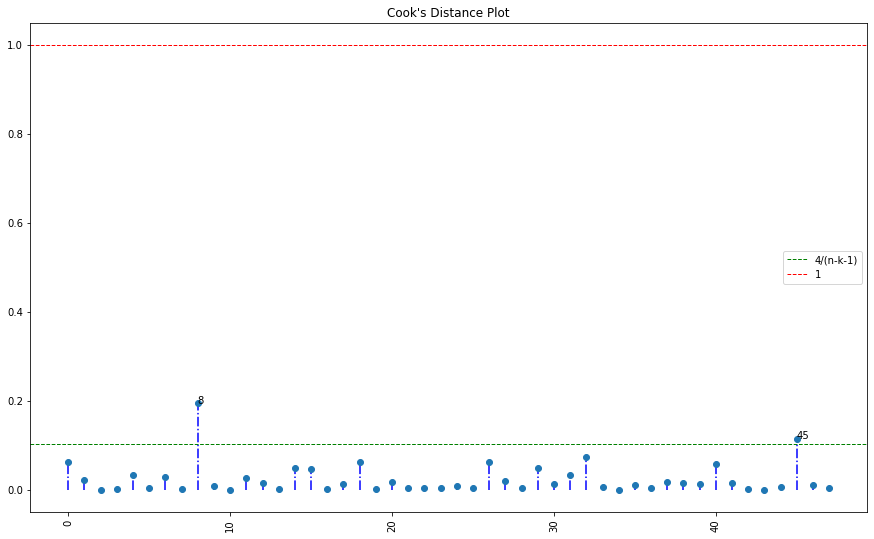

In [228]:
# test the selected model for influential observations using the function cooks_dist_plot
cooks_dist_plot(fit)


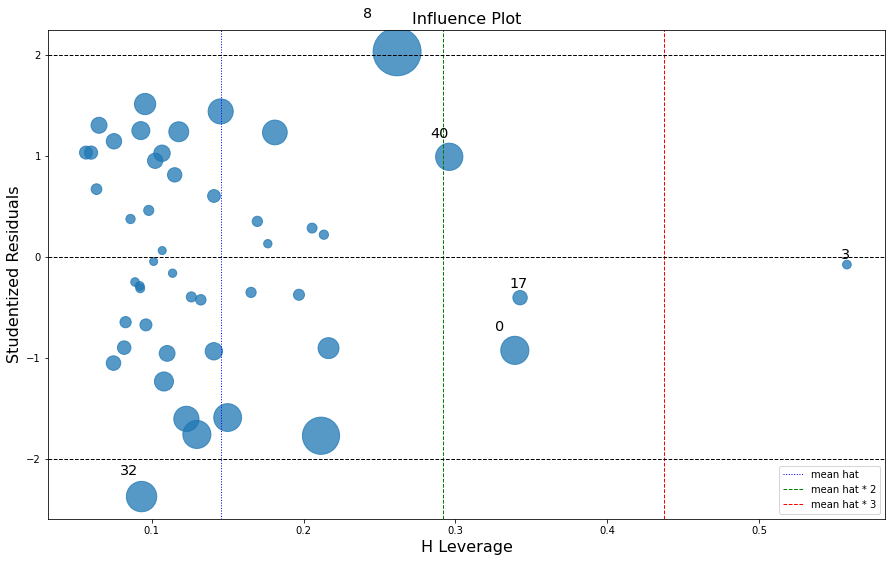

In [229]:
# test the selected model for influential observations using the seaborn function
fig, ax0 = plt.subplots(figsize=(15, 9))
sm.graphics.influence_plot(fit,  ax = ax0, criterion="Cooks")
# number of regressors + 1
p = len(fit.params)
# number of observations
n = len(fit.fittedvalues)
# mean hat value
mean_hat = p/n
ax0.axvline(x=mean_hat, color='b', linestyle='dotted', linewidth=1, label = "mean hat")
ax0.axvline(x=2*mean_hat, color='g', linestyle='--', linewidth=1, label = "mean hat * 2")
ax0.axvline(x=3*mean_hat, color='r', linestyle='--', linewidth=1, label = "mean hat * 3")
ax0.axhline(y=2, color='black', linestyle='--', linewidth=1)
ax0.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax0.axhline(y=-2, color='black', linestyle='--', linewidth=1)
ax0.legend()
plt.show()



### 4. Evaluation

## Best Fit Model
The best fit model from the forward stepwise regression algorithm and using the the adjusted R2 squared statistic along with the variance factor is
formula = 'LifeExp2018 ~ Income + South + MurderNMRate + Pop + West + BADegPer'
  
## Regression Diagnostics
### 1. Normality
From the Q-Q-Plot the residuals are normally distributed with a mean 0.
### 2. Linearity
The residuals vs. fitted values plot indicates that the dependent variable is linearly related to the independent variables because there is no systematic relationship between the residuals and the fitted values.
### 3. Constant Variance (Homocedasticity)
The Scale-Location graph shows that the sqrt_student_resid are randomly distributed around a horizontal line. An indication of homocedasticity.

## Unusual observations
### 1. Outliers
Two states - #8 Hawaii and #32 Ohio
### 2. High-leverage Points (Hat values greater than bound: 0.2917)
Four states - #0 Alaska, #3 California, #17 Maryland, #40 Texas
### 3. Influential Observations (Cooks Distance greater than bound)
Two States - #8 Hawaii and #45 West Virginia
### 4. Influence Plot
The most influential state is Hawaii.


